In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from pathlib import Path

import os
import torch

import typhon_model

import cv2
import ipywidgets as wg

## Choose model

In [2]:
root_path = Path('results')

experiments = sorted([path.stem for path in root_path.iterdir()])
exp_radiobuttons = widgets.RadioButtons(options=experiments, layout=widgets.Layout(width='600px')) # Add layout to avoid wrapping
display(exp_radiobuttons)

RadioButtons(layout=Layout(width='600px'), options=('20230501_fake_train_bus_6', '20230507_bbbbd3_load_100k_7'…

In [4]:
models_path = root_path / exp_radiobuttons.value / 'models'

models = sorted([path.stem for path in models_path.iterdir()])
models_radiobuttons = widgets.RadioButtons(options=models, layout=widgets.Layout(width='600px')) # Add layout to avoid wrapping
display(models_radiobuttons)

RadioButtons(layout=Layout(width='600px'), options=('bootstrap_model', 'spec_model_BRAIN_p', 'spec_model_BUSI_…

In [5]:
model_path = (root_path / exp_radiobuttons.value / 'models' / models_radiobuttons.value).with_suffix('.pth')
print(model_path)

# Load model
model_dict = torch.load(model_path, map_location=torch.device('cpu'))
model = typhon_model.TyphonModel.from_state_dict(model_dict)

results/20230512_load_bts4_4/models/spec_model_LINK_BRATS_LGG_flair_p.pth


/home/jonas/.local/share/virtualenvs/typhon_exp-7XDSMxwB/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jonas/.local/share/virtualenvs/typhon_exp-7XDSMxwB/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
dsets_radiobuttons = widgets.RadioButtons(options=model.dsets_names, layout=widgets.Layout(width='600px')) # Add layout to avoid wrapping
display(dsets_radiobuttons)

RadioButtons(layout=Layout(width='600px'), options=('LINK_BRATS_LGG_flair',), value='LINK_BRATS_LGG_flair')

## Load images and pass to model

In [7]:
def load_npy(path):
    ary = np.load(path)
    ary.shape = (1, 1, *ary.shape)
    # Convert to tenso
    img = torch.from_numpy(ary).float()
    return img

In [9]:
dset_choosen = dsets_radiobuttons.value
# input_folder_full = f'datasets_segmentation/{dset_choosen}/val/'
input_folder_full = f'datasets_segmentation/BRATS/LGG/flair/val/'
filename = np.random.choice([f for f in os.listdir(input_folder_full) if not f.endswith('_mask.npy')])
input_path = input_folder_full + filename
print(input_path)

inp = load_npy(input_path)
mask = load_npy(input_path[:-4] + '_mask.npy')

img_dim = (256, 256)
inp = torch.nn.functional.pad(inp, (0, img_dim[1], 0, img_dim[0]), 'constant', 0)[:, :, :img_dim[0], :img_dim[1]]
mask = torch.nn.functional.pad(mask, (0, img_dim[1], 0, img_dim[0]), 'constant', 0)[:, :, :img_dim[0], :img_dim[1]]

out_t = model.forward(inp, dset_choosen)

datasets_segmentation/BRATS/LGG/flair/val/BraTS19_2013_16_1_slice_107_t1.npy


In [10]:
def plot_results(inp, mask, out):
    # Format data
    arrays = (inp[0][0], mask[0][0], out.detach().numpy()[0][0])
    
    # Convert to right format
    uint_imgs = [np.array(array*255).astype('uint8') for array in arrays]
    grayImages = [cv2.cvtColor(uint_imgs[i], cv2.COLOR_GRAY2BGR) for i in range(len(arrays))]
    
    # Plot
    fig, axs = plt.subplots(1, len(arrays))
    [axs[i].imshow(grayImages[i]) for i in range(len(arrays))]
    
    plt.show()

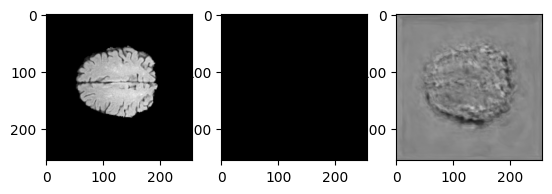

In [11]:
plot_results(inp, mask, out_t)

In [12]:
def plot_image(img):
    if type(img) == torch.Tensor:
        img = img.detach().numpy()
    while len(img.shape) > 2:
        img = img[0]
        
    uint_img = np.array(img*255).astype('uint8')   
    grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
    # set size
    plt.figure(figsize=(10,10))
    plt.axis("off")
    
    plt.imshow(grayImage)
    plt.show()

In [13]:
def f(x):
    return plot_image((inp, mask, out_t)[x%3])

wg.interact(f, x=wg.IntSlider(min=0,max=3,step=1));

interactive(children=(IntSlider(value=0, description='x', max=3), Output()), _dom_classes=('widget-interact',)…

In [14]:
opts = ['val', 'train', 'test']
type_radiobuttons = widgets.RadioButtons(options=opts, layout=widgets.Layout(width='600px')) # Add layout to avoid wrapping
display(type_radiobuttons)

RadioButtons(layout=Layout(width='600px'), options=('val', 'train', 'test'), value='val')

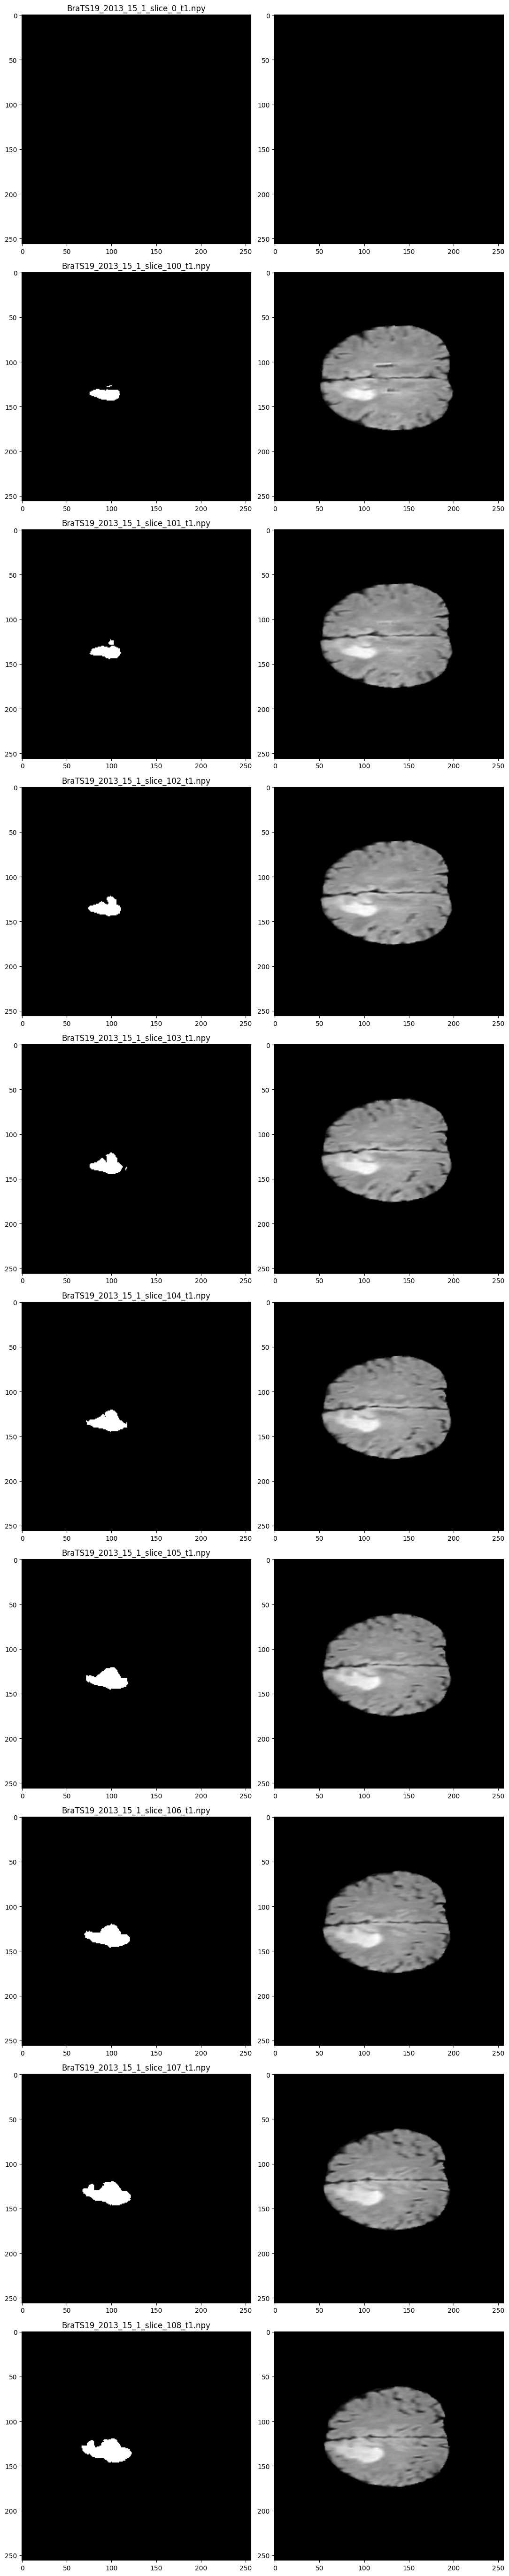

In [30]:
input_folder_full = f'datasets_segmentation/BRATS/LGG/flair/{type_radiobuttons.value}/'
all_files = [f for f in os.listdir(input_folder_full) if not f.endswith('_mask.npy')]

all_files = all_files[:80]

fig, axs = plt.subplots(len(all_files), 2, figsize=(11, int(5.5 * len(all_files))), squeeze=False)

outs = []
masks = []
for i, file in enumerate(sorted(all_files)):
    
    input_path = input_folder_full + file

    inp = load_npy(input_path)
    mask = load_npy(input_path[:-4] + '_mask.npy')

    img_dim = (256, 256)
    inp = torch.nn.functional.pad(inp, (0, img_dim[1], 0, img_dim[0]), 'constant', 0)[:, :, :img_dim[0], :img_dim[1]]
    mask = torch.nn.functional.pad(mask, (0, img_dim[1], 0, img_dim[0]), 'constant', 0)[:, :, :img_dim[0], :img_dim[1]]

#     out_t = model.forward(inp, dset_choosen)
    out_t = inp # Plot input instead
    
    outs.append(cv2.cvtColor((np.array(out_t.detach().numpy()[0][0])*255).astype('uint8'), cv2.COLOR_GRAY2BGR))
    masks.append(cv2.cvtColor((np.array(mask.detach().numpy()[0][0])*255).astype('uint8'), cv2.COLOR_GRAY2BGR))
    
    axs[i][0].imshow(cv2.cvtColor((np.array(mask.detach().numpy()[0][0])*255).astype('uint8'), cv2.COLOR_GRAY2BGR))
    axs[i][1].imshow(cv2.cvtColor((np.array(out_t.detach().numpy()[0][0])*255).astype('uint8'), cv2.COLOR_GRAY2BGR))
    axs[i][0].set_title(file)
    axs[i][0].set_title(file)
    
fig.tight_layout()
plt.show()

In [41]:
# plt.imshow(outs[-2])
im = outs[-2]
mk = masks[-2]

In [42]:
im.shape
mk.shape

(256, 256, 3)

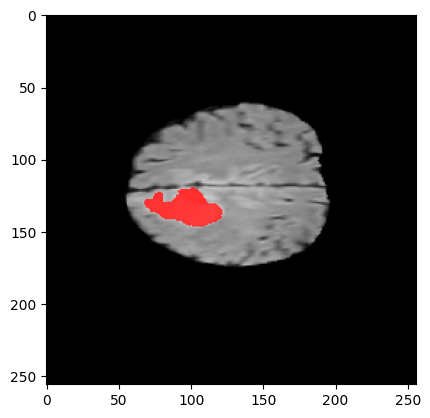

In [60]:
newim = im.copy()
for i in range(mk.shape[0]):
    for j in range(mk.shape[1]):
#         print(mk[i][j])
        if mk[i][j][2] == 255:
            newim[i][j][0] = 255
            newim[i][j][1] = int(im[i][j][1] * 0.25)
            newim[i][j][2] = int(im[i][j][2] * 0.25)

plt.imshow(newim)